In [1]:
MAKE_BOOK_FIGURES=True

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        
        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout settings
        'figure.constrained_layout.use': True,
        
        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

(max_post_example)=
# Maximum a Posteriori Estimate - Avoiding Overfitting

Let's load the motorcycle data to play with:

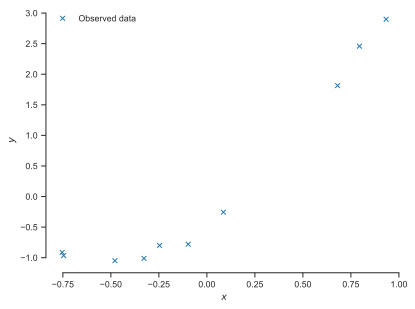

In [2]:
np.random.seed(123456)

num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1
y = (
    w0_true 
    + w1_true * x 
    + w2_true * x ** 2 
    + sigma_true * np.random.randn(num_obs)
)

fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Let's also copy-paste the code for creating design matrices for the three generalized linear models we have considered so far:

In [3]:
def get_polynomial_design_matrix(x, degree):
    """Return the polynomial design matrix of ``degree`` evaluated at ``x``.
    
    Arguments:
    x      -- A 2D array with only one column.
    degree -- An integer greater than zero.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    cols = []
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """Fourier expansion with ``num_terms`` cosines and sines.
    
    Arguments:
    x          --  A 2D array with only one column.
    L          --  The "length" of the domain.
    num_terms  --  How many Fourier terms do you want.
                   This is not the number of basis
                   functions you get. The number of basis functions
                   is 1 + num_terms / 2. The first one is a constant.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(int(num_terms / 2)):
        cols.append(np.cos(2 * (i+1) * np.pi / L * x))
        cols.append(np.sin(2 * (i+1) * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    """Radial basis functions design matrix.
    
    Arguments:
    x        --  The input points on which you want to evaluate the
                 design matrix.
    x_center --  The centers of the radial basis functions.
    ell      --  The lengthscale of the radial basis function.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

The problem that we need to solve to find the maximum a posteriori estimate is when the prior of the weights is a zero mean Gaussian with precision $\alpha$:

$$
\left(\sigma^{-2}\boldsymbol{\Phi}^T\boldsymbol{\Phi} + \alpha\mathbf{I}\right)\mathbf{w} = \sigma^{-2}\boldsymbol{\Phi}^T\mathbf{y}.
$$

This problem cannot be solved by ``numpy.linalg.lstsq``.
The stable way to solve this problem is this:

+ Construct the positive-definite matrix:

$$
\mathbf{A} = \left(\sigma^{-2}\mathbf{\Phi}^T\mathbf{\Phi}+\alpha\mathbf{I}\right)
$$

+ Compute the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\mathbf{A}$:

$$
\mathbf{A} = \mathbf{L}\mathbf{L}^T,
$$

where $\mathbf{L}$ is lower triangular.
+ Then, solve the system:

$$
\mathbf{L}\mathbf{L}^T\mathbf{w} = \sigma^{-2}\mathbf{\Phi}^T\mathbf{y}_{1:n},
$$

doing a forward and a backward substitution. The methods [scipy.linalg.cho_factor](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.cho_factor.html#scipy.linalg.cho_factor) and [scipy.linalg.cho_solve](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.cho_solve.html) can be used for this. We implement this process below:

In [4]:
# I need this to take the Cholesky decomposition
import scipy

def find_w_map(Phi, y, sigma2, alpha):
    """Return the MAP weights of a Bayesian linear regression problem.
    
    Arguments
    Phi    -- The design matrix.
    y      -- The observed targets.
    sigma2 -- The noise variance.
    aplha  -- The prior weight precision.
    """
    A = (
        Phi.T @ Phi / sigma2
        + alpha * np.eye(Phi.shape[1])
    )
    L = scipy.linalg.cho_factor(A)
    w = scipy.linalg.cho_solve(
        L,
        Phi.T @ y / sigma2
    )
    return w

Let's apply this to the synthetic dataset.
Select polynomial degree and get the design matrix:

In [5]:
degree = 6
Phi = get_polynomial_design_matrix(x[:, None], degree)

Pick variance (here I am using the actual one):

In [6]:
sigma2 = 0.1 ** 2

Pick the regularization parameter:

In [7]:
alpha = 100.0

Solve for the MAP of the weights:

In [8]:
w = find_w_map(Phi, y, sigma2, alpha)

Make predictions and plot the results:

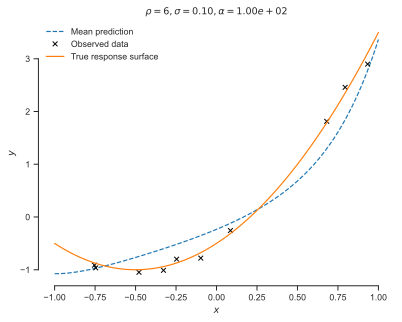

In [9]:
xx = np.linspace(-1, 1, 100)
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
Phi_xx = get_polynomial_design_matrix(
    xx[:, None],
    degree
)
yy = Phi_xx @ w

fig, ax = plt.subplots()
ax.plot(xx, yy, '--', label='Mean prediction')
ax.plot(x, y, 'kx', label='Observed data')
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(
    f'$\\rho={degree}, '
    + f'\\sigma = {np.sqrt(sigma2):1.2f}, '
    + f'\\alpha={alpha:1.2e}$'
)
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Questions

+ Experiment with different $\alpha$'s. Notice that for very small $\alpha$'s, we are overfitting. Notice that with very large $\alpha$'s, we are underfitting.

## Selecting $\alpha$ through a validation set

Let's plot the mean square error of a validation dataset as a function of $\alpha$.
First, here is our validation dataset:

In [10]:
x_valid = -1.0 + 2 * np.random.rand(20)
y_valid = (
    w0_true 
    + w1_true * x_valid 
    + w2_true * x_valid ** 2
    + sigma_true * np.random.randn(x_valid.shape[0])
)

We will take 50 $\alpha$'s between $0.01$ and $5$ and try each one of them out.

In [11]:
num_alphas = 50
min_alpha = 0.01
max_alpha = 10

# The alphas we will try
alphas = np.linspace(
    min_alpha,
    max_alpha,
    num_alphas
)

# To store the MSE:
MSEs = np.ndarray((num_alphas,))

# To store the weights
weights = np.ndarray((num_alphas, degree + 1))

for i, alpha in enumerate(alphas):
    w = find_w_map(Phi, y, sigma2, alpha)
    Phi_valid = get_polynomial_design_matrix(
        x_valid[:, None],
        degree
    )
    y_valid_predict = Phi_valid @ w
    MSE_alpha = np.linalg.norm(
        y_valid_predict - y_valid
    )
    MSEs[i] = MSE_alpha
    weights[i] = w

print("alpha\t MSE\t Weights")
print("-" * 60)
for alpha, mse, w in zip(alphas, MSEs, weights):
    print(
        f"{alpha:.3f}\t {mse:.3f}\t"
        + "[" +
        " ".join(
            [f"{wi:.2f}" for wi in w]
        )
        + "]"
    )

alpha	 MSE	 Weights
------------------------------------------------------------
0.010	 0.755	[-0.49 1.99 1.41 0.25 2.49 -0.12 -2.56]
0.214	 0.657	[-0.50 2.05 1.90 0.39 0.56 -0.59 -0.72]
0.418	 0.656	[-0.49 2.07 1.90 0.34 0.46 -0.56 -0.59]
0.622	 0.654	[-0.49 2.07 1.88 0.31 0.43 -0.54 -0.52]
0.826	 0.653	[-0.48 2.08 1.86 0.29 0.42 -0.53 -0.47]
1.029	 0.651	[-0.48 2.08 1.83 0.27 0.42 -0.51 -0.43]
1.233	 0.650	[-0.48 2.07 1.81 0.26 0.42 -0.50 -0.40]
1.437	 0.649	[-0.47 2.07 1.78 0.25 0.43 -0.49 -0.37]
1.641	 0.648	[-0.47 2.07 1.76 0.25 0.43 -0.48 -0.35]
1.845	 0.647	[-0.47 2.07 1.74 0.24 0.44 -0.47 -0.33]
2.049	 0.646	[-0.46 2.06 1.72 0.24 0.44 -0.46 -0.31]
2.253	 0.645	[-0.46 2.06 1.70 0.24 0.45 -0.45 -0.29]
2.457	 0.644	[-0.46 2.05 1.68 0.23 0.45 -0.44 -0.27]
2.660	 0.643	[-0.46 2.05 1.67 0.23 0.45 -0.43 -0.25]
2.864	 0.642	[-0.45 2.04 1.65 0.23 0.46 -0.42 -0.24]
3.068	 0.642	[-0.45 2.04 1.64 0.23 0.46 -0.41 -0.22]
3.272	 0.641	[-0.45 2.03 1.62 0.23 0.47 -0.40 -0.21]
3.476	 0.641	[-0.4

Let's now plot the MSE as a function of the alphas:

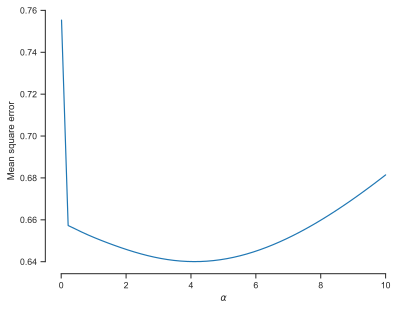

In [12]:
fig, ax = plt.subplots()
ax.plot(alphas, MSEs)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Mean square error')
sns.despine(trim=True);

We should pick the $\alpha$ with the smallest MSE.
Here is how:

In [13]:
min_mse_index = np.argmin(MSEs)
best_alpha = alphas[min_mse_index]
best_w = weights[min_mse_index]
print(f"Best alpha {best_alpha:.2f}")

Best alpha 4.09


Let's also plot the best fit:

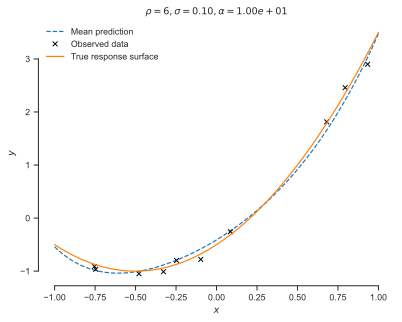

In [14]:
xx = np.linspace(-1, 1, 100)
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy = Phi_xx @ w

fig, ax = plt.subplots()
ax.plot(xx, yy, '--', label='Mean prediction')
ax.plot(x, y, 'kx', label='Observed data')
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'$\rho={0:d}, \sigma = {1:1.2f}, \alpha={2:1.2e}$'.format(degree, np.sqrt(sigma2), alpha))
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Questions
+ Rerun the code cell above with an $\alpha$ smaller than the optimal one. Observe how we overfit.
+ Rerun the code cell above with an $\alpha$ greater than the optimal one. Observe how we underfit.